# Kaggle - TMDB

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

### Original language

In [43]:
l_rev = {'en': 16.201695631547217,
 'fr': 13.718204235553607,
 'ru': 13.815132182879807,
 'es': 14.645970166012837,
 'hi': 15.371121660763546,
 'ja': 15.818050019285394,
 'it': 14.610307296701814,
 'ko': 14.561503498231747,
 'cn': 15.720496475312752,
 'zh': 15.246036823468886,
 'de': 14.583008872938295,
 'ta': 15.073328869838628}
train['l_rev'] = train['original_language'].map(l_rev).fillna(0)

### Collection

In [44]:
train['coll_id'] = train['belongs_to_collection'].fillna('[{"id":0}]').map(
    lambda x: (ast.literal_eval(x))[0]['id'])
colls = pd.read_csv('collections.csv',index_col=0)
train['coll_rev_logav'] = train['coll_id'].map(colls['log_of_averages']).fillna(0)

### genres

In [45]:
genres = pd.read_csv('genres.csv',index_col=0)
train['genres_id'] = train['genres'].fillna('[{"id":-1}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])
gen_rev = dict(genres['log_revenue'])
gen_rev[-1] = 0
train['genre_ave'] = train['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())

### production company

In [46]:
train['production_ids'] = train['production_companies'].fillna('[{"id":-123}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])
productions = pd.read_csv('production_companies_short.csv',index_col=0)
prod_rev = dict(productions['revenue'])
train['production_revs'] = train['production_ids'].map(lambda x: ([prod_rev[p] for p in x if p in prod_rev]))
train['prod_ave'] = train['production_revs'].map(lambda x: np.array(x).mean() if len(x)>0 else 0)
train['prod_top'] = train['production_revs'].map(lambda x: np.array(x).max() if len(x)>0 else 0)

### release_date

In [47]:
train['year'] = train['release_date'].map(lambda x: (x.split('/'))[2])
train['year'] = train['year'].astype(int)
train['year'] = train['year'].map(lambda x: x+1900 if x>17 else x+2000)

In [69]:
train['production_countries'].fillna('[]').map(lambda x: len(ast.literal_eval(x))).value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

In [74]:
train['prod_countries'] = train['production_countries'].fillna('[]').map(
    lambda x: [i['iso_3166_1'] for i in ast.literal_eval(x)])

In [77]:
all_c = []
for i in train['prod_countries']:
    all_c.extend(i)

In [100]:
unique = set(all_c)
counts = {}
for c in unique:
    counts[c] = (np.array(all_c) == c).sum()
len([c for c in counts if counts[c]>50])

11

In [125]:
cutoff = 50
for country in [c for c in counts if counts[c]>cutoff]:
    train[f'country_{country}'] = train['prod_countries'].map(lambda x: 1 if country in x else 0)
countries = [f'country_{c}' for c in counts if counts[c]>50]

In [126]:
train[['prod_countries',*countries]].head(20)

,prod_countries,country_IN,country_FR,country_JP,country_RU,country_GB,country_ES,country_IT,country_DE,country_US,country_CA,country_AU
0,[US],0,0,0,0,0,0,0,0,1,0,0
1,[US],0,0,0,0,0,0,0,0,1,0,0
2,[US],0,0,0,0,0,0,0,0,1,0,0
3,[IN],1,0,0,0,0,0,0,0,0,0,0
4,[KR],0,0,0,0,0,0,0,0,0,0,0
5,[],0,0,0,0,0,0,0,0,0,0,0
6,"[US, CA]",0,0,0,0,0,0,0,0,1,1,0
7,[],0,0,0,0,0,0,0,0,0,0,0
8,[US],0,0,0,0,0,0,0,0,1,0,0
9,[US],0,0,0,0,0,0,0,0,1,0,0


### Fitting

In [127]:
boost = GradientBoostingRegressor()

In [128]:
y = train['revenue'].map(math.log)

In [129]:
# best score so far (reference)
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.063932168124893

In [130]:
# best score so far (reference)
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year',*countries]

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.056995280833391

In [152]:
for cutoff in range(0,50,5):
    for country in [c for c in counts if counts[c]>cutoff]:
        train[f'country_{country}'] = train['prod_countries'].map(lambda x: 1 if country in x else 0)
    countries = [f'country_{c}' for c in counts if counts[c]>cutoff]

    columns = ['popularity','budget',
               'l_rev',
               'coll_rev_logav',
               'genre_ave',
              'prod_top','prod_ave',
               'year',*countries]

    X = train[columns]
    print(cutoff,-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean())

0 4.157824185834579
5 4.1844435474733555
10 4.175452379150089
15 4.175256490614165
20 4.18583776305809
25 4.068064371841514
30 4.065145349626462
35 4.0678419981327725
40 4.0672852527179355
45 4.0566477280482545


In [153]:
for cutoff in range(50,100,5):
    for country in [c for c in counts if counts[c]>cutoff]:
        train[f'country_{country}'] = train['prod_countries'].map(lambda x: 1 if country in x else 0)
    countries = [f'country_{c}' for c in counts if counts[c]>cutoff]

    columns = ['popularity','budget',
               'l_rev',
               'coll_rev_logav',
               'genre_ave',
              'prod_top','prod_ave',
               'year',*countries]

    X = train[columns]
    print(cutoff,-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean())

50 4.056458525111589
55 4.071022870492553
60 4.085421315431265
65 4.053260438067461
70 4.053697446516341
75 4.058354199608219
80 4.060938000976755
85 4.099770725297082
90 4.099934000093183
95 4.1025074758308575


### Test set

In [142]:
test['l_rev'] = test['original_language'].map(l_rev).fillna(13.61844005781211)

In [143]:
test['coll_id'] = test['belongs_to_collection'].fillna('[{"id":0}]').map(lambda x: (ast.literal_eval(x))[0]['id'])
test['coll_rev_logav'] = test['coll_id'].map(colls['log_of_averages']).fillna(0)

In [144]:
test['genres_id'] = test['genres'].fillna('[{"id":-1}]').map(lambda x: [i['id'] for i in (ast.literal_eval(x))])
test['genre_ave'] = test['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())

In [145]:
test['production_ids'] = test['production_companies'].fillna('[{"id":-123}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])

In [146]:
test['production_revs'] = test['production_ids'].map(lambda x: ([prod_rev[p] for p in x if p in prod_rev]))

In [147]:
test['prod_ave'] = test['production_revs'].map(lambda x: np.array(x).mean() if len(x)>0 else 0)
test['prod_top'] = test['production_revs'].map(lambda x: np.array(x).max() if len(x)>0 else 0)

In [148]:
# missing value - I filled with wikipedia info
test.loc[828,'release_date'] = '05/01/00'

In [149]:
test['year'] = test['release_date'].map(lambda x: (x.split('/'))[2])
test['year'] = test['year'].astype(int)
test['year'] = test['year'].map(lambda x: x+1900 if x>17 else x+2000)

In [150]:
test['prod_countries'] = test['production_countries'].fillna('[]').map(
    lambda x: [i['iso_3166_1'] for i in ast.literal_eval(x)])
for country in [c for c in counts if counts[c]>50]:
    test[f'country_{country}'] = test['prod_countries'].map(lambda x: 1 if country in x else 0)

In [151]:
submit = pd.read_csv('sample_submission.csv',index_col='id')
submit.head()

,revenue
id,
3001,1000000
3002,1000000
3003,1000000
3004,1000000
3005,1000000


In [156]:
cutoff = 50
for country in [c for c in counts if counts[c]>cutoff]:
    train[f'country_{country}'] = train['prod_countries'].map(lambda x: 1 if country in x else 0)
countries = [f'country_{c}' for c in counts if counts[c]>cutoff]

columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year',*countries]

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-prod_c_50.csv')

In [157]:
cutoff = 70
for country in [c for c in counts if counts[c]>cutoff]:
    train[f'country_{country}'] = train['prod_countries'].map(lambda x: 1 if country in x else 0)
countries = [f'country_{c}' for c in counts if counts[c]>cutoff]

columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year',*countries]

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-prod_c_70.csv')

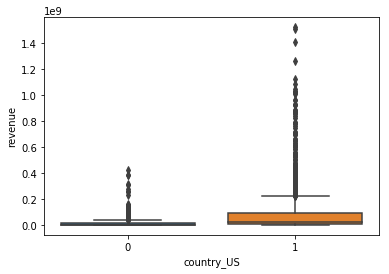

In [160]:
sns.boxplot(x='country_US',y='revenue',data=train)

In [161]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','country_US']

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-prod_c_US.csv')